## Part 1: Association Rule Mining

### 0'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# Package Installation
try:
    import mlxtend
except:
    !pip install mlxtend

try:
    import wordcloud
except:
    !pip install wordcloud

try:
    import networkx
except:
    !pip install networkx

try:
    import plotly
except:
    !pip install plotly


from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from collections import Counter
from wordcloud import WordCloud
import networkx as nx
import plotly.express as px

import warnings
warnings.filterwarnings(action='ignore')

### 1` 데이터 변환

In [ ]:
file_path = 'big_student_clear_third_version.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,Unnamed: 0,institute,course_id,year,semester,userid_DI,viewed,explored,certified,final_cc_cname_DI,...,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts,incomplete_flag,age
0,4,HarvardX,PH207x,2012,Fall,MHxPC130313697,0,0,0,India,...,0.0,2012-07-24,2013-07-27,6,3,197757,0,0,0,23
1,6,HarvardX,PH207x,2012,Fall,MHxPC130237753,1,0,0,United States,...,0.0,2012-07-24,2012-12-24,107,8,7,2,0,0,19
2,7,HarvardX,CS50x,2012,Summer,MHxPC130202970,1,0,0,United States,...,0.0,2012-07-24,2013-03-28,8,1,197757,1,0,0,24
3,20,HarvardX,CS50x,2012,Summer,MHxPC130223941,1,0,0,Other Middle East/Central Asia,...,0.0,2012-07-24,2013-07-15,25,2,197757,4,0,0,20
4,22,HarvardX,PH207x,2012,Fall,MHxPC130317399,0,0,0,Australia,...,0.0,2012-07-24,2012-08-25,3,2,197757,0,0,0,32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416921 entries, 0 to 416920
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         416921 non-null  int64  
 1   institute          416921 non-null  object 
 2   course_id          416921 non-null  object 
 3   year               416921 non-null  int64  
 4   semester           416921 non-null  object 
 5   userid_DI          416921 non-null  object 
 6   viewed             416921 non-null  int64  
 7   explored           416921 non-null  int64  
 8   certified          416921 non-null  int64  
 9   final_cc_cname_DI  416921 non-null  object 
 10  LoE_DI             416921 non-null  object 
 11  gender             393710 non-null  object 
 12  grade              416921 non-null  float64
 13  start_time_DI      416921 non-null  object 
 14  last_event_DI      416921 non-null  object 
 15  nevents            416921 non-null  int64  
 16  nd

In [ ]:
columns_needed = ['userid_DI', 'institute', 'course_id', 'final_cc_cname_DI', 'LoE_DI']
df = data[columns_needed]
df['Item Name'] = df['institute'] + '_' + df['course_id'] + '_' + df['final_cc_cname_DI'] + '_' + df['LoE_DI']
df = df.rename(columns={'userid_DI': 'Transaction ID'})
df = df[['Transaction ID', 'Item Name']]
df.head()

,Transaction ID,Item Name
0,MHxPC130313697,HarvardX_PH207x_India_Bachelor's
1,MHxPC130237753,HarvardX_PH207x_United States_Secondary
2,MHxPC130202970,HarvardX_CS50x_United States_Bachelor's
3,MHxPC130223941,HarvardX_CS50x_Other Middle East/Central Asia_...
4,MHxPC130317399,HarvardX_PH207x_Australia_Master's


In [ ]:
grouped_df = df.groupby('Transaction ID')['Item Name'].apply(list).reset_index()
grouped_df.columns = ['Transaction ID', 'Item Name']
grouped_df.head()

,Transaction ID,Item Name
0,MHxPC130000002,[MITx_14.73x_United Kingdom_Secondary]
1,MHxPC130000004,"[HarvardX_CS50x_India_Secondary, HarvardX_ER22..."
2,MHxPC130000006,[HarvardX_ER22x_United States_Bachelor's]
3,MHxPC130000007,[HarvardX_CB22x_United States_Master's]
4,MHxPC130000008,[MITx_6.00x_United Kingdom_Bachelor's]


In [ ]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335650 entries, 0 to 335649
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  335650 non-null  object
 1   Item Name       335650 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [ ]:
df.to_csv('single.csv', index=False)

In [ ]:
grouped_df.to_csv('group.csv', index=False)

### 2`기초 통계량 확인


#### 2-1) 탐색적 데이터 분석

In [ ]:
# Check the structure of the data
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416921 entries, 0 to 416920
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  416921 non-null  object
 1   Item Name       416921 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [ ]:
data[['Institution', 'Course Code', 'Country', 'Degree']] = data['Item Name'].str.split('_', expand=True)
# Split 'Item Name' into separate columns
data[['Institution', 'Course Code', 'Country', 'Degree']] = data['Item Name'].str.split('_', expand=True)
data.head()

,Transaction ID,Item Name,Institution,Course Code,Country,Degree
0,MHxPC130313697,HarvardX_PH207x_India_Bachelor's,HarvardX,PH207x,India,Bachelor's
1,MHxPC130237753,HarvardX_PH207x_United States_Secondary,HarvardX,PH207x,United States,Secondary
2,MHxPC130202970,HarvardX_CS50x_United States_Bachelor's,HarvardX,CS50x,United States,Bachelor's
3,MHxPC130223941,HarvardX_CS50x_Other Middle East/Central Asia_...,HarvardX,CS50x,Other Middle East/Central Asia,Secondary
4,MHxPC130317399,HarvardX_PH207x_Australia_Master's,HarvardX,PH207x,Australia,Master's


In [ ]:
# Calculate value counts for each split column
institution_counts = data['Institution'].value_counts()
course_code_counts = data['Course Code'].value_counts()
country_counts = data['Country'].value_counts()
degree_counts = data['Degree'].value_counts()

# Display the results
institution_counts, course_code_counts, country_counts, degree_counts

(Institution
 MITx        240119
 HarvardX    176802
 Name: count, dtype: int64,
 Course Code
 6.00x     104143
 6.002x     47219
 CS50x      46332
 ER22x      40521
 PH207x     36557
 CB22x      28123
 PH278x     25269
 14.73x     23402
 8.02x      21164
 7.00x      16740
 3.091x     15906
 8.MReV      7151
 2.01x       4394
 Name: count, dtype: int64,
 Country
 United States                             129648
 India                                      70205
 Other Europe                               30973
 Other Africa                               18854
 United Kingdom                             15708
 Brazil                                     13787
 Other Middle East/Central Asia             13641
 Other South Asia                           10102
 Canada                                      8404
 Egypt                                       7493
 Russian Federation                          7272
 Spain                                       7244
 Pakistan                          

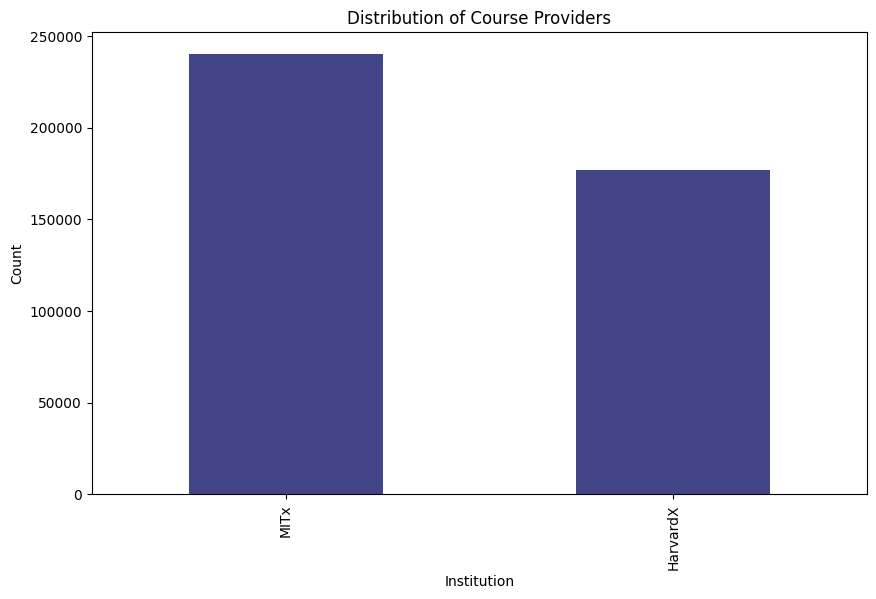

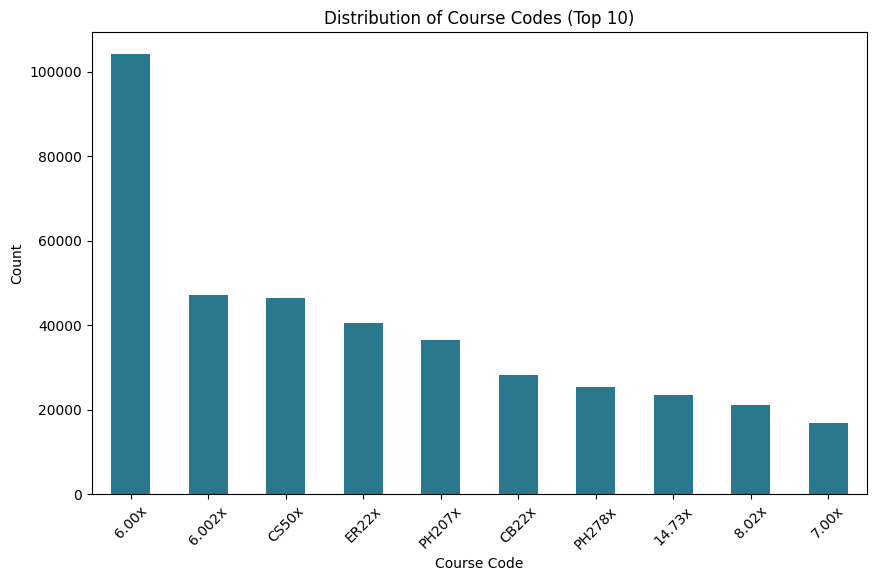

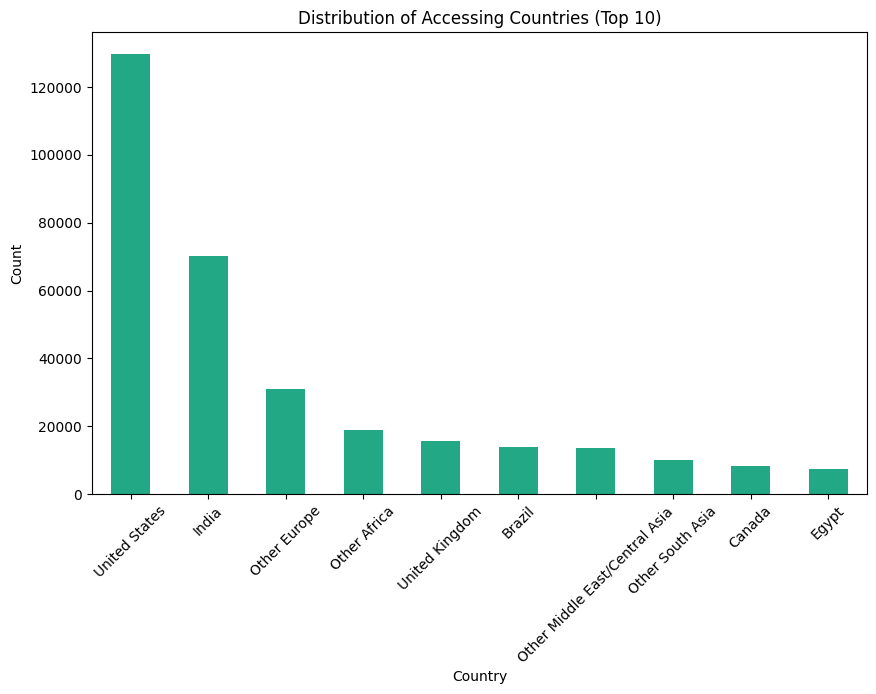

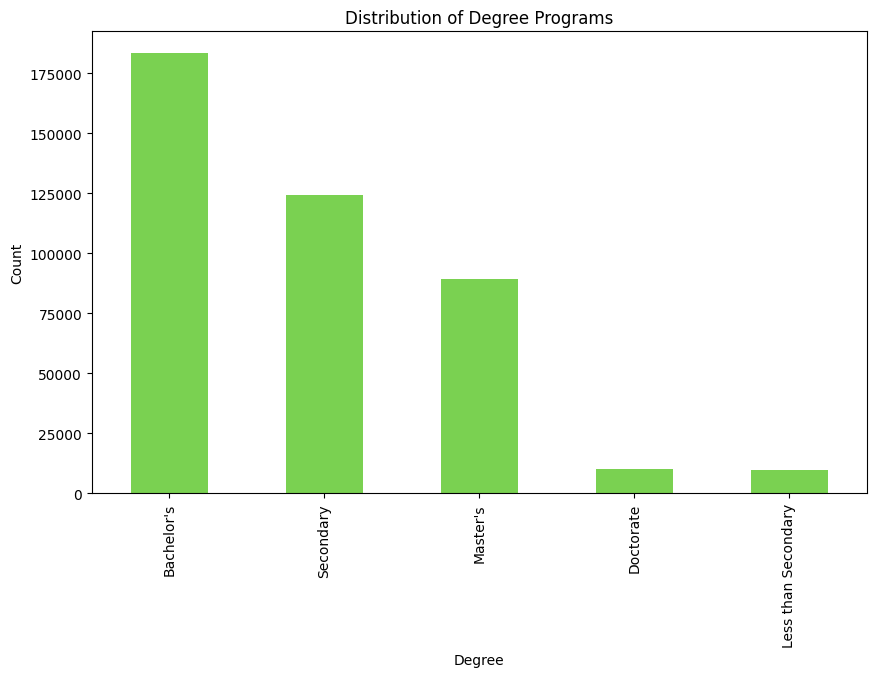

In [ ]:
color_palette = plt.cm.viridis

# Institution distribution
plt.figure(figsize=(10, 6))
institution_counts.plot(kind='bar', color=color_palette(0.2))
plt.title('Distribution of Course Providers')
plt.ylabel('Count')
plt.show()

# Course Code distribution (Top 10)
plt.figure(figsize=(10, 6))
course_code_counts.head(10).plot(kind='bar', color=color_palette(0.4))
plt.title('Distribution of Course Codes (Top 10)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Country distribution (Top 10)
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar', color=color_palette(0.6))
plt.title('Distribution of Accessing Countries (Top 10)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Degree distribution
plt.figure(figsize=(10, 6))
degree_counts.plot(kind='bar', color=color_palette(0.8))
plt.title('Distribution of Degree Programs')
plt.ylabel('Count')
plt.show()

In [ ]:
data = grouped_df
unique_items = data['Item Name'].value_counts()
unique_count = data['Item Name'].nunique()

unique_count, unique_items.head()

(14062,
 Item Name
 ["MITx_6.00x_United States_Bachelor's"]        10654
 ['MITx_6.00x_United States_Secondary']          6671
 ["MITx_6.00x_India_Bachelor's"]                 5729
 ["MITx_6.002x_India_Bachelor's"]                5430
 ["HarvardX_CS50x_United States_Bachelor's"]     5300
 Name: count, dtype: int64)

#### 2-2 ) 워드클라우드

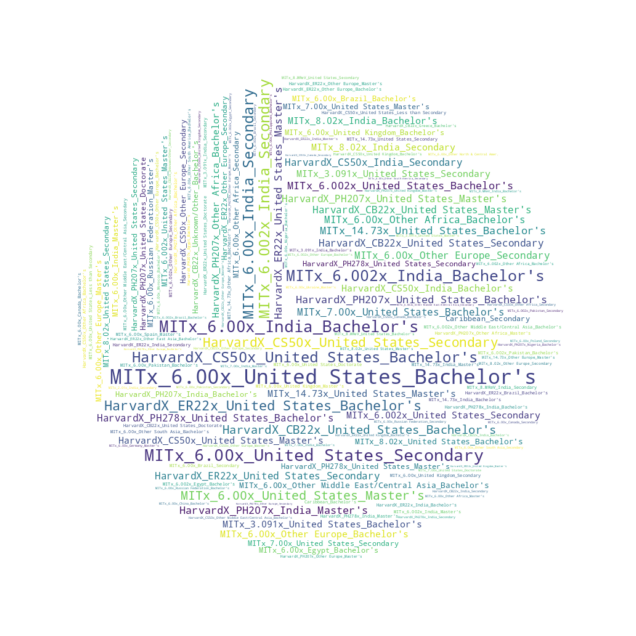

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import numpy as np

items = ",".join(df['Item Name'].values.tolist()).split(',')
items = [item.strip() for item in items]
item_count = Counter(items)

x, y = np.ogrid[:1000, :1000]
mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(
    width=1000,
    height=500,
    mask=mask,
    background_color='white'
).generate_from_frequencies(item_count)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### 2-3) Bar Chart

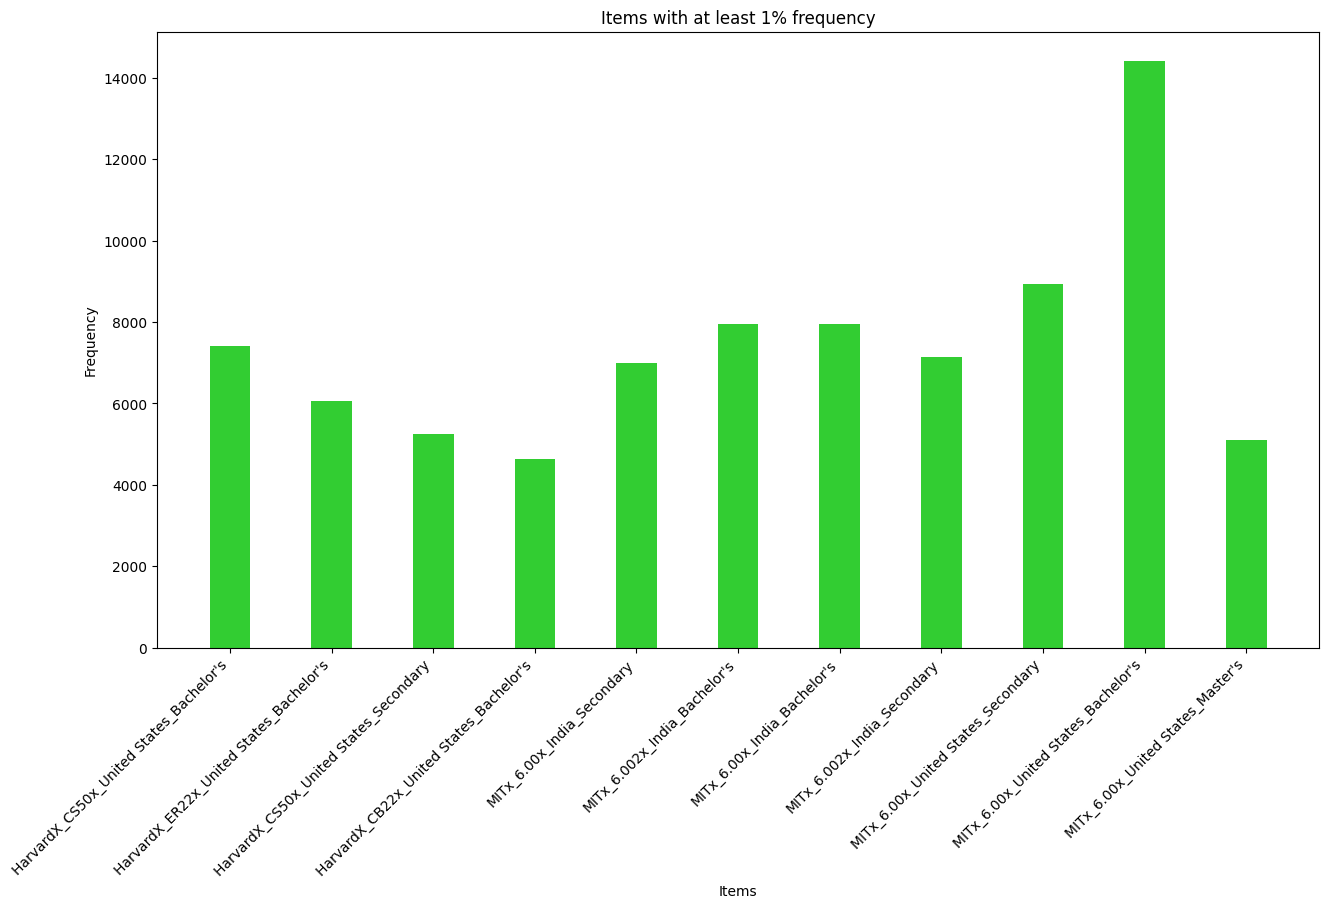

,Countries
MITx_6.00x_United States_Bachelor's,United States
MITx_6.00x_United States_Secondary,United States
MITx_6.00x_India_Bachelor's,India
MITx_6.002x_India_Bachelor's,India
HarvardX_CS50x_United States_Bachelor's,United States


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# 아이템 이름 리스트 생성
items = ",".join(df['Item Name'].values.tolist()).split(',')
items = [item.strip() for item in items]
item_count = Counter(items)

# 최소 빈도 1% 이상 등장한 아이템 필터링
total_items = sum(item_count.values())
min_frequency = 0.01 * total_items
filtered_items = {item: count for item, count in item_count.items() if count >= min_frequency}

# 상위 5개 아이템 추출
top_5_items = dict(Counter(filtered_items).most_common(5))

# 아이템 별로 접속 국가 확인
top_5_items_countries = {}
for item in top_5_items.keys():
    countries = df[df['Item Name'].str.contains(item, regex=False)]['Item Name'].apply(lambda x: x.split('_')[-2]).unique()
    top_5_items_countries[item] = countries

plt.figure(figsize=(15, 8))
plt.bar(filtered_items.keys(), filtered_items.values(), color='limegreen', width=0.4)
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Items with at least 1% frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

# 상위 5개 아이템과 각 아이템의 접속 국가 데이터프레임 생성 및 표시
top_5_items_countries_df = pd.DataFrame.from_dict(top_5_items_countries, orient='index', columns=['Countries'])
display(top_5_items_countries_df)

### 3`규칙 생성 및 결과 해석


In [ ]:
import pandas as pd
df = pd.read_csv('single.csv')
grouped_df = pd.read_csv('group.csv')

In [ ]:
filtered_items

{"HarvardX_CS50x_United States_Bachelor's": 7410,
 "HarvardX_ER22x_United States_Bachelor's": 6053,
 'HarvardX_CS50x_United States_Secondary': 5260,
 "HarvardX_CB22x_United States_Bachelor's": 4640,
 'MITx_6.00x_India_Secondary': 7002,
 "MITx_6.002x_India_Bachelor's": 7951,
 "MITx_6.00x_India_Bachelor's": 7963,
 'MITx_6.002x_India_Secondary': 7140,
 'MITx_6.00x_United States_Secondary': 8944,
 "MITx_6.00x_United States_Bachelor's": 14412,
 "MITx_6.00x_United States_Master's": 5093}

In [ ]:
filter = list(filtered_items)
filter

["HarvardX_CS50x_United States_Bachelor's",
 "HarvardX_ER22x_United States_Bachelor's",
 'HarvardX_CS50x_United States_Secondary',
 "HarvardX_CB22x_United States_Bachelor's",
 'MITx_6.00x_India_Secondary',
 "MITx_6.002x_India_Bachelor's",
 "MITx_6.00x_India_Bachelor's",
 'MITx_6.002x_India_Secondary',
 'MITx_6.00x_United States_Secondary',
 "MITx_6.00x_United States_Bachelor's",
 "MITx_6.00x_United States_Master's"]

In [ ]:
# Define the filter list
file_path = 'group.csv'
data = pd.read_csv(file_path)
filter_list = filter
# Function to filter item lists
def filter_items(item_list, filter_list):
    # Remove leading and trailing spaces and single quotes
    cleaned_items = [item.strip().strip("'") for item in item_list]
    # Filter items based on the filter list
    filtered_items = [item for item in cleaned_items if item in filter_list]
    return filtered_items

# Apply the filter function to the 'Item Name' column
data['Filtered Items'] = data['Item Name'].apply(lambda x: filter_items(eval(x), filter_list))
data.head()


,Transaction ID,Item Name,Filtered Items
0,MHxPC130000002,['MITx_14.73x_United Kingdom_Secondary'],[]
1,MHxPC130000004,"['HarvardX_CS50x_India_Secondary', 'HarvardX_E...",[]
2,MHxPC130000006,"[""HarvardX_ER22x_United States_Bachelor's""]",[HarvardX_ER22x_United States_Bachelor's]
3,MHxPC130000007,"[""HarvardX_CB22x_United States_Master's""]",[]
4,MHxPC130000008,"[""MITx_6.00x_United Kingdom_Bachelor's""]",[]


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335650 entries, 0 to 335649
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  335650 non-null  object
 1   Item Name       335650 non-null  object
 2   Filtered Items  335650 non-null  object
dtypes: object(3)
memory usage: 7.7+ MB


In [ ]:
# Remove transactions with empty filtered items
filtered_data = data[data['Filtered Items'].apply(len) > 0]

# Replace the 'Item Name' column with 'Filtered Items' content
filtered_data['Item Name'] = filtered_data['Filtered Items']

# Drop the 'Filtered Items' column as it is no longer needed
filtered_data = filtered_data.drop(columns=['Filtered Items'])
filtered_data.head()

,Transaction ID,Item Name
2,MHxPC130000006,[HarvardX_ER22x_United States_Bachelor's]
10,MHxPC130000024,"[HarvardX_CB22x_United States_Bachelor's, Harv..."
12,MHxPC130000027,[MITx_6.00x_United States_Secondary]
17,MHxPC130000034,[HarvardX_CS50x_United States_Secondary]
23,MHxPC130000057,[MITx_6.00x_United States_Master's]


In [ ]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74518 entries, 2 to 335645
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Transaction ID  74518 non-null  object
 1   Item Name       74518 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [ ]:
# Load the data
filtered_data = pd.read_csv('filter.csv')

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

filtered_data['Item Name'] = filtered_data['Item Name'].apply(lambda x: eval(x))
transactions = filtered_data['Item Name'].tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)
results = pd.DataFrame(columns=['Support', 'Confidence = 0.03', 'Confidence = 0.05', 'Confidence = 0.07'])

# 지원도 및 신뢰도 설정
supports = [0.001, 0.002, 0.003]
confidences = [0.03, 0.05, 0.07]

# 각 지원도 및 신뢰도에 대해 규칙의 수 계산
for support in supports:
    row = {'Support': support}
    frequent_itemsets = apriori(df_trans, min_support=support, use_colnames=True, verbose=True)

    for confidence in confidences:
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=confidence)
        row[f'Confidence = {confidence}'] = len(rules)

    # row를 DataFrame으로 변환하고 concat으로 추가
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

# 결과 출력
results

Processing 4 combinations | Sampling itemset size 4
Processing 84 combinations | Sampling itemset size 3
Processing 84 combinations | Sampling itemset size 3


,Support,Confidence = 0.03,Confidence = 0.05,Confidence = 0.07
0,0.001,28,27,24
1,0.002,16,15,12
2,0.003,16,15,12


In [ ]:
frequent_itemsets = apriori(df_trans, min_support=0.001, use_colnames=True, verbose=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.05)
rules


Processing 4 combinations | Sampling itemset size 4


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(HarvardX_CB22x_United States_Bachelor's),(HarvardX_CS50x_United States_Bachelor's),0.062267,0.099439,0.004791,0.076940,0.773737,-0.001401,0.975625,-0.237716
1,(HarvardX_ER22x_United States_Bachelor's),(HarvardX_CB22x_United States_Bachelor's),0.081229,0.062267,0.011662,0.143565,2.305644,0.006604,1.094926,0.616347
2,(HarvardX_CB22x_United States_Bachelor's),(HarvardX_ER22x_United States_Bachelor's),0.062267,0.081229,0.011662,0.187284,2.305644,0.006604,1.130496,0.603884
3,(HarvardX_CB22x_United States_Bachelor's),(MITx_6.00x_United States_Bachelor's),0.062267,0.190451,0.004616,0.074138,0.389276,-0.007242,0.874374,-0.625895
4,(HarvardX_ER22x_United States_Bachelor's),(HarvardX_CS50x_United States_Bachelor's),0.081229,0.099439,0.005073,0.062448,0.628006,-0.003005,0.960545,-0.391990
5,(HarvardX_CS50x_United States_Bachelor's),(HarvardX_ER22x_United States_Bachelor's),0.099439,0.081229,0.005073,0.051012,0.628006,-0.003005,0.968159,-0.396771
6,(MITx_6.00x_United States_Bachelor's),(HarvardX_CS50x_United States_Bachelor's),0.190451,0.099439,0.016412,0.086175,0.866614,-0.002526,0.985485,-0.159752
7,(HarvardX_CS50x_United States_Bachelor's),(MITx_6.00x_United States_Bachelor's),0.099439,0.190451,0.016412,0.165047,0.866614,-0.002526,0.969575,-0.145964
8,(HarvardX_CS50x_United States_Secondary),(MITx_6.00x_United States_Secondary),0.070587,0.118642,0.009018,0.127757,1.076821,0.000643,1.010449,0.076758
9,(MITx_6.00x_United States_Secondary),(HarvardX_CS50x_United States_Secondary),0.118642,0.070587,0.009018,0.076010,1.076821,0.000643,1.005869,0.080943


In [ ]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         27 non-null     object 
 1   consequents         27 non-null     object 
 2   antecedent support  27 non-null     float64
 3   consequent support  27 non-null     float64
 4   support             27 non-null     float64
 5   confidence          27 non-null     float64
 6   lift                27 non-null     float64
 7   leverage            27 non-null     float64
 8   conviction          27 non-null     float64
 9   zhangs_metric       27 non-null     float64
 10  utility             27 non-null     float64
dtypes: float64(9), object(2)
memory usage: 2.4+ KB


In [ ]:
highest_support_rule = rules.loc[rules['support'].idxmax()]

# Confidence가 가장 높은 규칙 찾기
highest_confidence_rule = rules.loc[rules['confidence'].idxmax()]

# Lift가 가장 높은 규칙 찾기
highest_lift_rule = rules.loc[rules['lift'].idxmax()]

# 효용성 지표 계산 (Support × Confidence × Lift)
rules['utility'] = rules['support'] * rules['confidence'] * rules['lift']

# 효용성이 가장 높은 규칙 1위~3위 찾기
top_3_utility_rules = rules.nlargest(3, 'utility')

# 결과 출력
print("Support가 가장 높은 규칙:\n", highest_support_rule)
print("\nConfidence가 가장 높은 규칙:\n", highest_confidence_rule)
print("\nLift가 가장 높은 규칙:\n", highest_lift_rule)
print("\n효용성이 가장 높은 규칙 1위~3위:\n", top_3_utility_rules)

Support가 가장 높은 규칙:
 antecedents               (MITx_6.00x_United States_Bachelor's)
consequents           (HarvardX_CS50x_United States_Bachelor's)
antecedent support                                     0.190451
consequent support                                     0.099439
support                                                0.016412
confidence                                             0.086175
lift                                                   0.866614
leverage                                              -0.002526
conviction                                             0.985485
zhangs_metric                                         -0.159752
utility                                                0.001226
Name: 6, dtype: object

Confidence가 가장 높은 규칙:
 antecedents           (HarvardX_ER22x_United States_Bachelor's, MITx...
consequents                   (HarvardX_CS50x_United States_Bachelor's)
antecedent support                                             0.004415
consequent su

In [ ]:
highest_lift_rule[0]

frozenset({"HarvardX_CS50x_United States_Bachelor's",
           "HarvardX_ER22x_United States_Bachelor's"})

In [ ]:
top_3_utility_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,utility
14,(MITx_6.002x_India_Secondary),(MITx_6.00x_India_Secondary),0.091951,0.092031,0.016332,0.177612,1.929909,0.007869,1.104064,0.530633,0.005598
13,(MITx_6.00x_India_Secondary),(MITx_6.002x_India_Secondary),0.092031,0.091951,0.016332,0.177457,1.929909,0.007869,1.103953,0.530680,0.005593
2,(HarvardX_CB22x_United States_Bachelor's),(HarvardX_ER22x_United States_Bachelor's),0.062267,0.081229,0.011662,0.187284,2.305644,0.006604,1.130496,0.603884,0.005036


### 4`시각화 및 해석

#### 4-1`Bubble plot

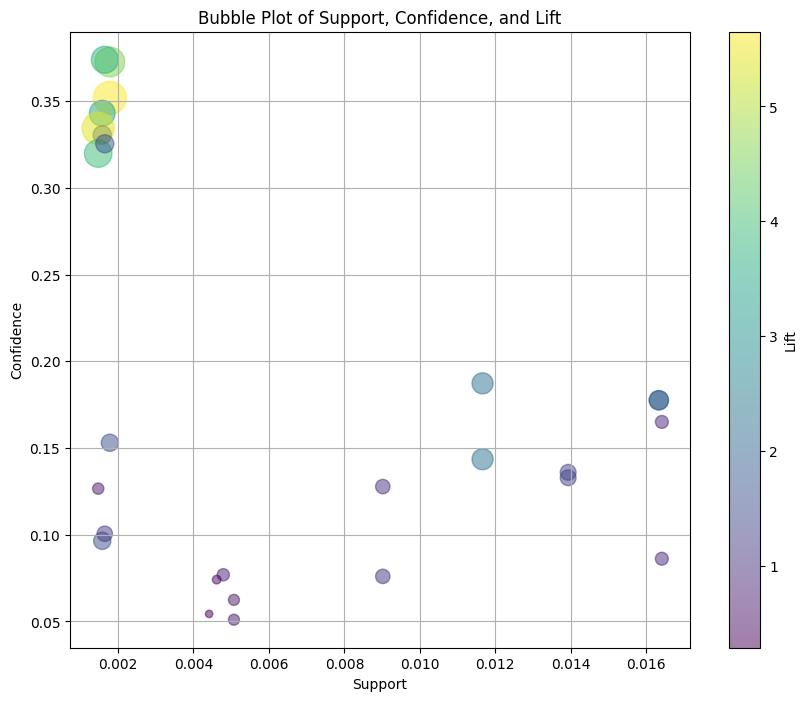

In [ ]:
rules_df = rules
import matplotlib.pyplot as plt

# Create a bubble plot
plt.figure(figsize=(10, 8))

# Bubble plot with support on x-axis, confidence on y-axis, and lift as bubble size
plt.scatter(rules_df['support'], rules_df['confidence'],
            s=rules_df['lift']*100, alpha=0.5, c=rules_df['lift'], cmap='viridis')

plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Bubble Plot of Support, Confidence, and Lift')
plt.colorbar(label='Lift')
plt.grid(True)
plt.show()

#### 4-2` Radial Plot

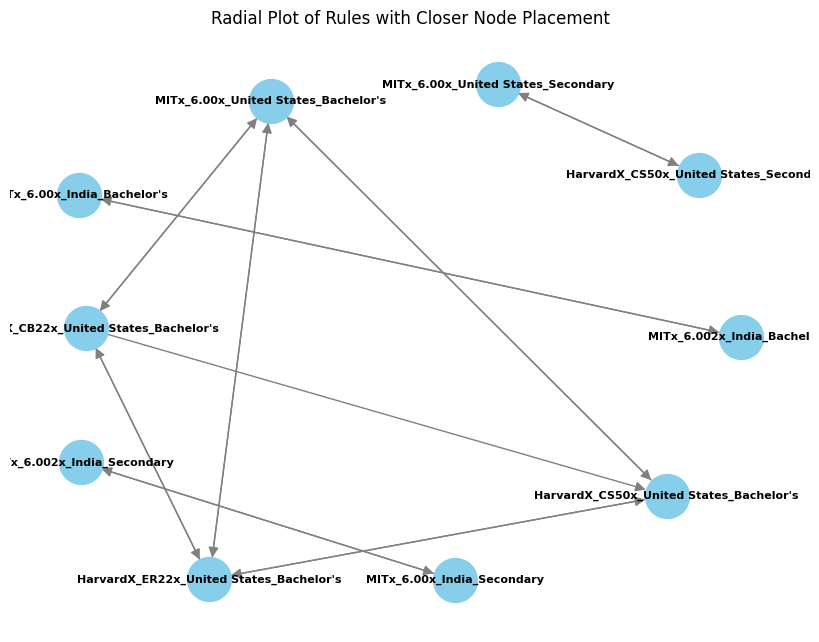

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

file_path = 'rules.csv'
rules_df = pd.read_csv(file_path)

edges = rules_df[['antecedents', 'consequents']]
edges['antecedents'] = edges['antecedents'].apply(lambda x: list(eval(x))[0])
edges['consequents'] = edges['consequents'].apply(lambda x: list(eval(x))[0])

G = nx.from_pandas_edgelist(edges, 'antecedents', 'consequents', create_using=nx.DiGraph)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, k=5)  # k controls the distance between nodes, smaller value for closer nodes
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=8,
        font_weight="bold", edge_color="gray", arrows=True, arrowsize=15)

plt.title("Radial Plot of Rules with Closer Node Placement")
plt.show()

In [ ]:
pip install squarify

#### 4-3` TreeMap

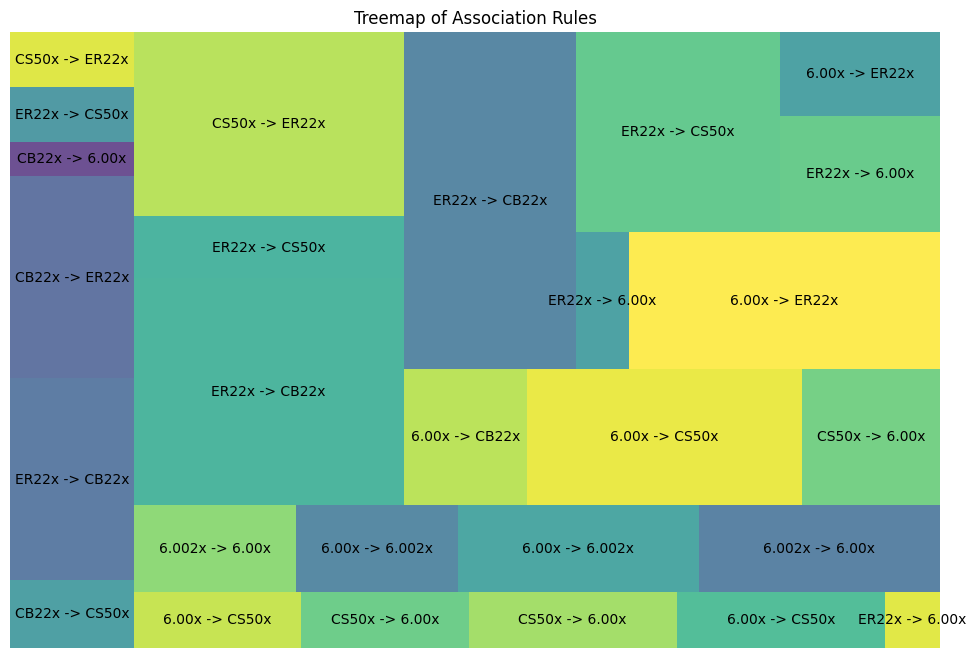

In [ ]:
import matplotlib.pyplot as plt
import squarify

file_path = 'rules.csv'
data = pd.read_csv(file_path)
# 데이터 변환
data['antecedents'] = data['antecedents'].apply(lambda x: list(eval(x))[0].split('_')[1])
data['consequents'] = data['consequents'].apply(lambda x: list(eval(x))[0].split('_')[1])
data['label'] = data['antecedents'] + ' -> ' + data['consequents']
data['value'] = data['lift']

# Treemap 그리기
plt.figure(figsize=(12, 8))
squarify.plot(sizes=data['value'], label=data['label'], alpha=0.8)
plt.axis('off')
plt.title('Treemap of Association Rules')
plt.show()


## Part 2: Clustering

### 1` 데이터셋 선정하기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('AutoInsurance.csv')

In [4]:
X = df.columns.values.tolist()

In [5]:
#label encoder
label_encoder = LabelEncoder()

def encoder(st):
    df[st]= label_encoder.fit_transform(df[st])
    df[st].unique()

d = df.dtypes
j = 0
for i in d:
    if(i == object):
        encoder(X[j])
    j+=1
df.head(5)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,600,4,2763.519279,0,0,0,40,1,0,56274,...,5,0,1,0,2,0,0,384.811147,5,1
1,5946,0,6979.535903,0,1,0,20,4,0,0,...,42,0,8,1,5,2,0,1131.464935,0,1
2,96,2,12887.431650,0,2,0,34,1,0,48767,...,38,0,2,1,5,0,0,566.472247,5,1
3,8016,1,7645.861827,0,0,0,9,4,1,0,...,65,0,7,0,1,0,2,529.881344,3,1
4,2488,4,2813.692575,0,0,0,46,1,1,43836,...,44,0,1,1,3,0,0,138.130879,0,1


In [6]:
X.remove('Customer')
X.remove('Effective To Date')
X

['State',
 'Customer Lifetime Value',
 'Response',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Gender',
 'Income',
 'Location Code',
 'Marital Status',
 'Monthly Premium Auto',
 'Months Since Last Claim',
 'Months Since Policy Inception',
 'Number of Open Complaints',
 'Number of Policies',
 'Policy Type',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Total Claim Amount',
 'Vehicle Class',
 'Vehicle Size']

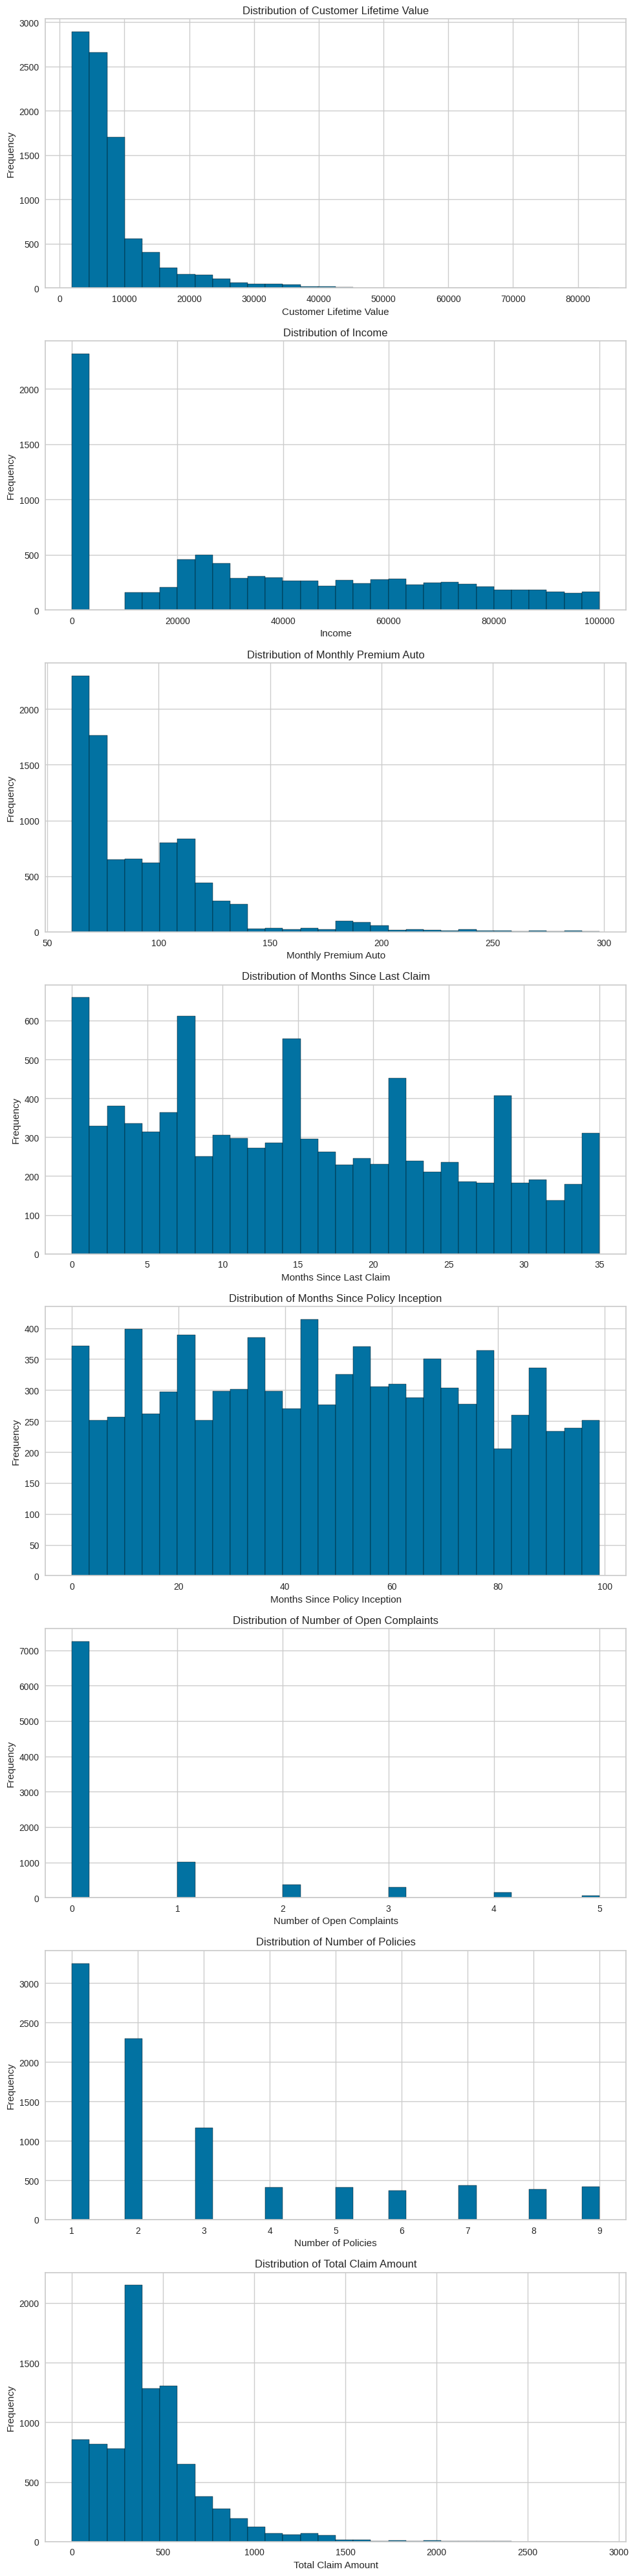

In [ ]:
import matplotlib.pyplot as plt
data = pd.read_csv('AutoInsurance.csv')
# Select only numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Plot distribution for each numeric column
fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(10, len(numeric_columns) * 5))

for i, col in enumerate(numeric_columns):
    ax = axes[i]
    data[col].hist(bins=30, ax=ax, edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

import scipy.stats as stats
from scipy.spatial import ConvexHull

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, DBSCAN

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer

### 2` K-Means Clustering

#### 2-Q2`

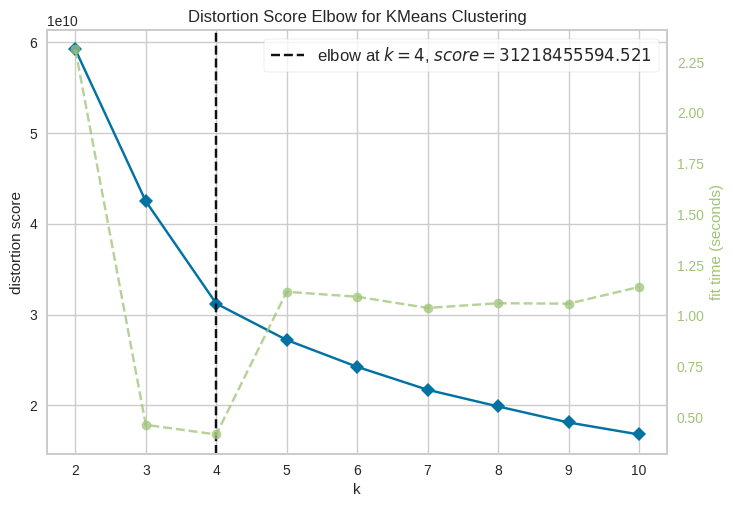

Elapsed time: 10.24 seconds


In [ ]:
from yellowbrick.cluster import KElbowVisualizer
import time

def elbow_method(data):
    start_time = time.time()
    Elbow_M = KElbowVisualizer(KMeans(), locate_elbow=True)
    Elbow_M.fit(data)
    Elbow_M.show()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    return

elbow_method(df[X])

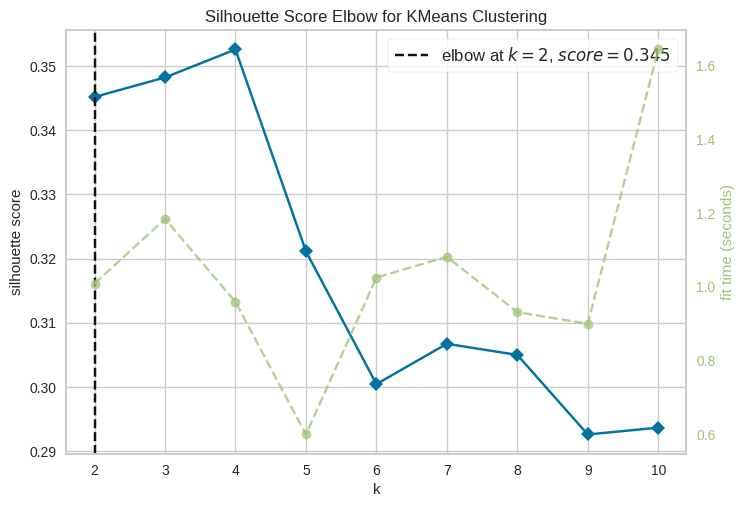

Elapsed time: 15.98 seconds


In [ ]:
from yellowbrick.cluster import KElbowVisualizer
import time

def elbow_method(data):
    start_time = time.time()
    Elbow_M = KElbowVisualizer(KMeans(), locate_elbow=True,metric = 'silhouette')
    Elbow_M.fit(data)
    Elbow_M.show()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    return

elbow_method(df[X])

#### 2-Q3`

In [8]:
# Standardizing the data
scaler = StandardScaler()
df = scaler.fit_transform(df[X])

In [ ]:
df.shape

(9134, 22)

In [ ]:
# Number of clusters
results = []
for i in range(10):
    kmeans = KMeans(n_clusters=4, n_init=20, random_state=i)
    kmeans.fit(df)

    centroids = np.round(kmeans.cluster_centers_, 3)
    labels = kmeans.labels_
    sizes = pd.Series(labels).value_counts().sort_index().values

    for j in range(4):
        result = {
            'Iteration': i+1,
            'Cluster': j,
            'Centroid': centroids[j],
            'Size': sizes[j]
        }
        results.append(result)


results_df = pd.DataFrame(results)
results_df

,Iteration,Cluster,Centroid,Size
0,1,0,"[0.023, -0.089, 0.065, 0.007, -0.05, 1.423, 0....",2140
1,1,1,"[0.01, -0.001, -0.139, -0.067, 0.027, -0.535, ...",1644
2,1,2,"[-0.007, 0.055, 0.011, 0.01, 0.033, -0.638, -0...",3705
3,1,3,"[-0.024, -0.007, 0.03, 0.034, -0.036, 0.119, 0...",1645
4,2,0,"[-0.007, 0.055, 0.011, 0.01, 0.033, -0.638, -0...",3705
...,...,...,...,...
35,9,3,"[0.023, -0.089, 0.065, 0.008, -0.05, 1.424, 0....",2140
36,10,0,"[-0.007, 0.055, 0.011, 0.011, 0.033, -0.637, -...",3706
37,10,1,"[0.009, -0.001, -0.14, -0.068, 0.027, -0.535, ...",1644
38,10,2,"[0.023, -0.09, 0.065, 0.007, -0.049, 1.424, 0....",2139


In [ ]:
# 표시할 최대 줄 수와 열 수 설정
pd.set_option('display.max_rows', 39)
pd.set_option('display.max_columns', 8)
results_df

,Iteration,Cluster,Centroid,Size
0,1,0,"[0.023, -0.089, 0.065, 0.007, -0.05, 1.423, 0....",2140
1,1,1,"[0.01, -0.001, -0.139, -0.067, 0.027, -0.535, ...",1644
2,1,2,"[-0.007, 0.055, 0.011, 0.01, 0.033, -0.638, -0...",3705
3,1,3,"[-0.024, -0.007, 0.03, 0.034, -0.036, 0.119, 0...",1645
4,2,0,"[-0.007, 0.055, 0.011, 0.01, 0.033, -0.638, -0...",3705
...,...,...,...,...
35,9,3,"[0.023, -0.089, 0.065, 0.008, -0.05, 1.424, 0....",2140
36,10,0,"[-0.007, 0.055, 0.011, 0.011, 0.033, -0.637, -...",3706
37,10,1,"[0.009, -0.001, -0.14, -0.068, 0.027, -0.535, ...",1644
38,10,2,"[0.023, -0.09, 0.065, 0.007, -0.049, 1.424, 0....",2139


In [ ]:
CENTROID_THRESHOLD = 5
SIZE_THRESHOLD_PERCENT = 0.01
unique_results = []

for i, row in results_df.iterrows():
    centroids = row['Centroid']
    size = row['Size']
    cluster = row['Cluster']

    matched = False
    for result in unique_results:
        common_elements = sum(1 for x, y in zip(centroids, result['Centroid']) if x == y)
        size_difference = abs(size - result['Size']) / max(size, result['Size'])

        if common_elements >= CENTROID_THRESHOLD and size_difference <= SIZE_THRESHOLD_PERCENT:
            result['Count'] += 1
            result['Iterations'].append(row['Iteration'])
            result['Clusters'].append(cluster)
            matched = True
            break

    if not matched:
        unique_results.append({
            'Centroid': centroids,
            'Size': size,
            'Count': 1,
            'Iterations': [row['Iteration']],
            'Clusters': [cluster]
        })

# 결과를 데이터프레임 형태로 변환
final_results_df = pd.DataFrame(unique_results)
final_results_df['Cluster_Numbers'] = final_results_df['Clusters'].apply(lambda x: list(set(x)))
final_results_df


,Centroid,Size,Count,Iterations,Clusters,Cluster_Numbers
0,"[0.023, -0.089, 0.065, 0.007, -0.05, 1.423, 0....",2140,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[0, 3, 3, 1, 3, 0, 2, 0, 3, 2]","[0, 1, 2, 3]"
1,"[0.01, -0.001, -0.139, -0.067, 0.027, -0.535, ...",1644,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 2, 3, 2, 2, 0, 3, 2, 1]","[0, 1, 2, 3]"
2,"[-0.007, 0.055, 0.011, 0.01, 0.033, -0.638, -0...",3705,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[2, 0, 1, 2, 0, 1, 3, 2, 1, 0]","[0, 1, 2, 3]"
3,"[-0.024, -0.007, 0.03, 0.034, -0.036, 0.119, 0...",1645,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[3, 1, 0, 0, 1, 3, 1, 1, 0, 3]","[0, 1, 3]"


#### 2-Q4`

In [ ]:
kmeans = KMeans(n_clusters=4, n_init=100, random_state=0)
kmeans.fit(df)
print('Cluster centers')
print(kmeans.cluster_centers_)
print()
print('Cluster size')
print(np.unique(kmeans.labels_, return_counts=True))
print()
print('Cluster Labels')
print(kmeans.labels_)

Cluster centers
[[ 0.00795333 -0.00174476 -0.13982126 -0.06732074  0.02618847 -0.53328249
  -0.10714739  0.67430828 -1.6164606  -0.21168201 -0.1609972   0.04184981
   0.00287004  0.00780083 -0.0072108   0.03493567  0.05323789  0.15384979
   0.02220934 -1.57411101 -0.02550388 -0.20288806]
 [-0.02239558 -0.00599264  0.03052353  0.03418747 -0.03517556  0.11804164
   0.0211463  -0.15550005  0.28859834  0.02423756  0.0465699   0.02134914
   0.002786   -0.03737425  0.01517237 -1.73527274 -1.55660407 -0.03685397
  -0.00502119  0.30166759  0.00261959  0.04615762]
 [-0.00694312  0.0548912   0.01112628  0.0104113   0.03264097 -0.63750236
  -0.00301702  0.38136811  0.55143085 -0.20148656  0.03873293 -0.02940526
  -0.02661211  0.00706907 -0.01306147  0.47857969  0.41937279  0.08768889
   0.01653706  0.21163517  0.00751713  0.07093055]
 [ 0.02311185 -0.08908872  0.06476749  0.00746006 -0.04961973  1.42296051
   0.07134159 -1.059142    0.06615454  0.49293367  0.02092242  0.00233905
   0.04172731  0.

In [ ]:
# Compare each cluster for KMC
kmc_cluster = kmeans.labels_
cluster_kmc = pd.concat([
    pd.DataFrame(df, columns=X),
    pd.DataFrame(kmc_cluster, columns=['clusterID'])
], axis=1)
kmc_summary = cluster_kmc.groupby('clusterID').mean()
kmc_summary = kmc_summary.transpose()
kmc_summary

clusterID,0,1,2,3
State,0.007953,-0.022396,-0.006943,0.023112
Customer Lifetime Value,-0.001745,-0.005993,0.054891,-0.089089
Response,-0.139821,0.030524,0.011126,0.064767
Coverage,-0.067321,0.034187,0.010411,0.007460
Education,0.026188,-0.035176,0.032641,-0.049620
EmploymentStatus,-0.533282,0.118042,-0.637502,1.422961
Gender,-0.107147,0.021146,-0.003017,0.071342
Income,0.674308,-0.155500,0.381368,-1.059142
Location Code,-1.616461,0.288598,0.551431,0.066155
Marital Status,-0.211682,0.024238,-0.201487,0.492934


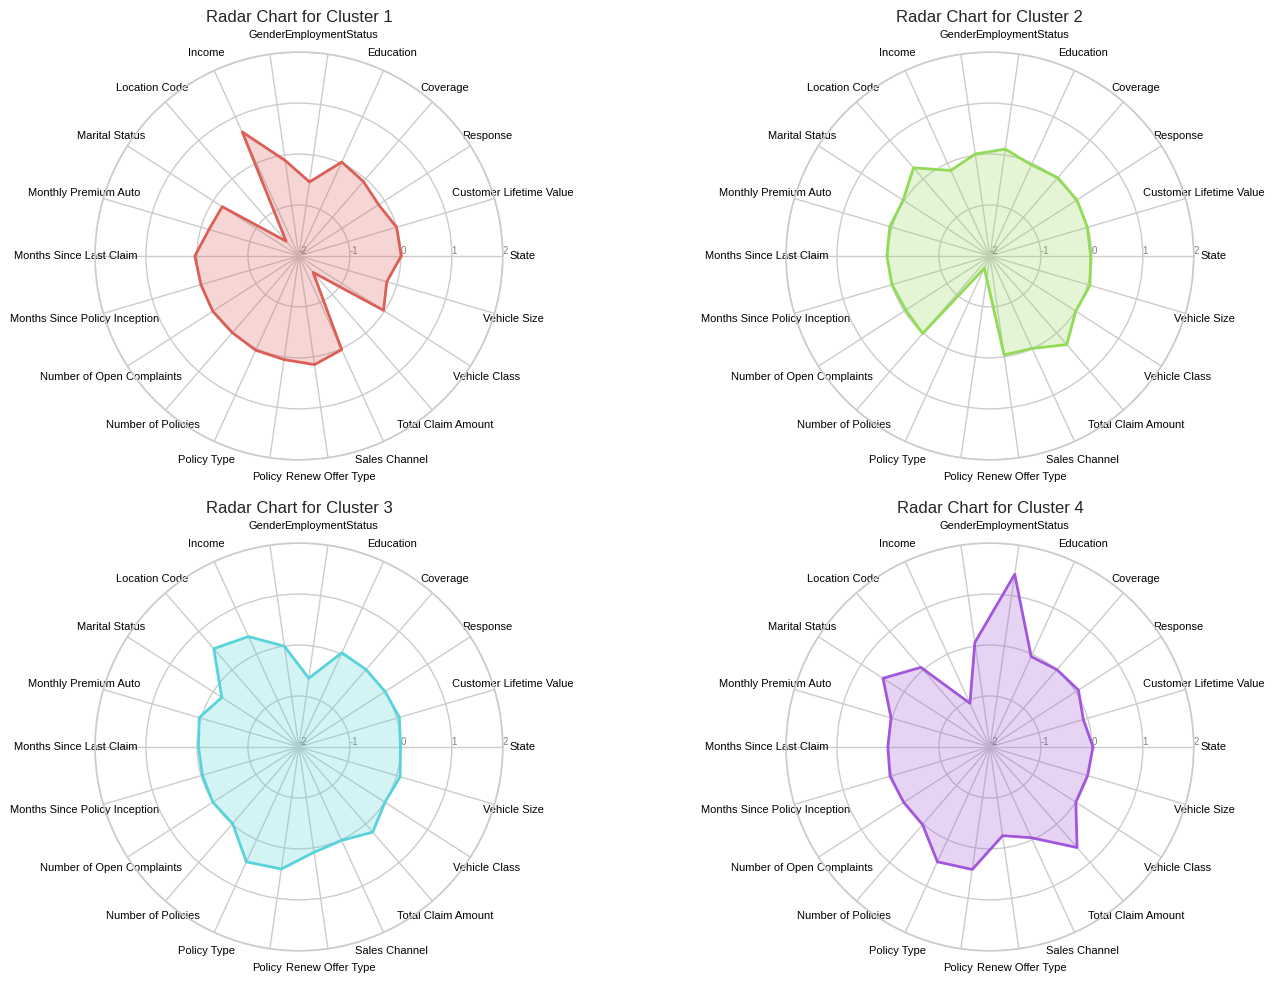

In [ ]:
# Plotting the Radar Chart
categories = kmc_summary.index.tolist()
N = len(categories)

# Divide the plot / number of variable
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(2, 2, figsize=(14, 10), subplot_kw=dict(projection="polar"))
ax = ax.flatten()

# Plot each individual = each line of the data
colors = sns.color_palette("hls", 4)

for i in range(kmc_summary.shape[1]):
    values = kmc_summary.iloc[:, i].values.flatten().tolist()
    values += values[:1]
    ax[i].plot(angles, values, linewidth=2, linestyle='solid', label="Cluster " + str(i+1), color=colors[i])
    ax[i].fill(angles, values, color=colors[i], alpha=0.25)

    # 각 변수에 대해 라벨 설정
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(categories, color='black', size=8)

    # y축 라벨 설정
    ax[i].set_rlabel_position(0)
    ax[i].set_yticks([-2, -1, 0, 1, 2])
    ax[i].set_yticklabels(["-2", "-1", "0", "1", "2"], color="grey", size=7)

    # 타이틀 설정
    ax[i].set_title(f'Radar Chart for Cluster {i+1}')

plt.tight_layout()
plt.show()

#### 2-Q5`

In [ ]:
df[X]

# Compare the first and the second cluster
kmc_cluster1 = df[X].loc[kmeans.labels_ == 0,:]
kmc_cluster2 = df[X].loc[kmeans.labels_ == 3,:]

# t_test_result
kmc_t_result = pd.DataFrame(columns=['two_sided', 'greater', 'less'])

for i in range(kmc_cluster1.shape[1]):
    two_sided = stats.ttest_ind(kmc_cluster1.iloc[:, i], kmc_cluster2.iloc[:, i], equal_var=False)[1]
    greater = stats.ttest_ind(kmc_cluster1.iloc[:, i], kmc_cluster2.iloc[:, i], equal_var=False, alternative='greater')[1]
    less = stats.ttest_ind(kmc_cluster1.iloc[:, i], kmc_cluster2.iloc[:, i], equal_var=False, alternative='less')[1]

    kmc_t_result.loc[i] = [two_sided, greater, less]

kmc_t_result

,two_sided,greater,less
0,6.444141e-01,6.777930e-01,3.222070e-01
1,4.187012e-01,2.093506e-01,7.906494e-01
2,3.668657e-11,1.000000e+00,1.834329e-11
3,1.829747e-02,9.908513e-01,9.148735e-03
4,2.198061e-02,1.099030e-02,9.890097e-01
5,0.000000e+00,1.000000e+00,0.000000e+00
6,4.839188e-08,1.000000e+00,2.419594e-08
7,0.000000e+00,0.000000e+00,1.000000e+00
8,0.000000e+00,1.000000e+00,0.000000e+00
9,1.027714e-104,1.000000e+00,5.138569e-105


In [ ]:
df = kmc_t_result
significant_vars = (df["two_sided"] < 0.05).sum()

# 전체 변수 수
total_vars = df.shape[0]
significant_indices = df[df["two_sided"] < 0.05].index
significant_variables = [X[i] for i in significant_indices]
print(significant_indices)
print(significant_variables)

significant_proportion = significant_vars / total_vars
significant_proportion

Index([1, 4, 5, 7, 8, 9, 15, 16, 17, 19], dtype='int64')
['Customer Lifetime Value', 'Education', 'EmploymentStatus', 'Income', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type', 'Total Claim Amount']


0.45454545454545453

In [ ]:
# Compare the first and the second cluster
kmc_cluster1 = df[X].loc[kmeans.labels_ == 1,:]
kmc_cluster2 = df[X].loc[kmeans.labels_ == 2,:]

# t_test_result
kmc_t_result = pd.DataFrame(columns=['two_sided', 'greater', 'less'])

for i in range(kmc_cluster1.shape[1]):
    two_sided = stats.ttest_ind(kmc_cluster1.iloc[:, i], kmc_cluster2.iloc[:, i], equal_var=False)[1]
    greater = stats.ttest_ind(kmc_cluster1.iloc[:, i], kmc_cluster2.iloc[:, i], equal_var=False, alternative='greater')[1]
    less = stats.ttest_ind(kmc_cluster1.iloc[:, i], kmc_cluster2.iloc[:, i], equal_var=False, alternative='less')[1]

    kmc_t_result.loc[i] = [two_sided, greater, less]

kmc_t_result

,two_sided,greater,less
0,5.977882e-01,7.011059e-01,2.988941e-01
1,7.533885e-03,9.962331e-01,3.766943e-03
2,5.229882e-01,2.614941e-01,7.385059e-01
3,4.332188e-01,2.166094e-01,7.833906e-01
4,2.150261e-02,9.892487e-01,1.075131e-02
5,3.178223e-149,1.589112e-149,1.000000e+00
6,4.150833e-01,2.075417e-01,7.924583e-01
7,4.693828e-94,1.000000e+00,2.346914e-94
8,2.006583e-29,1.000000e+00,1.003291e-29
9,2.339886e-14,1.169943e-14,1.000000e+00


In [ ]:
df = kmc_t_result
significant_vars = (df["two_sided"] < 0.05).sum()

# 전체 변수 수
total_vars = df.shape[0]
significant_indices = df[df["two_sided"] < 0.05].index
significant_variables = [X[i] for i in significant_indices]
print(significant_indices)
print(significant_variables)

significant_proportion = significant_vars / total_vars
significant_proportion

Index([1, 4, 5, 7, 8, 9, 15, 16, 17, 19], dtype='int64')
['Customer Lifetime Value', 'Education', 'EmploymentStatus', 'Income', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type', 'Total Claim Amount']


0.45454545454545453

### 3` Hierarichal Clustering

#### 3-Q6`

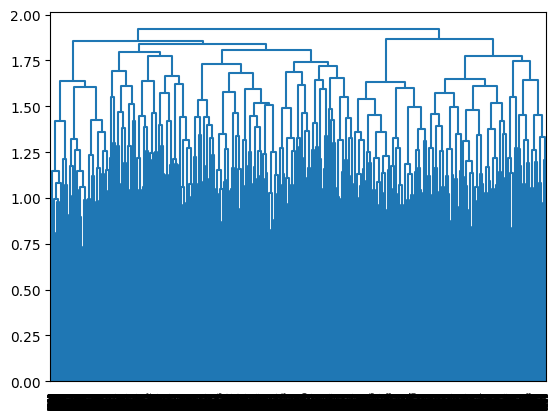

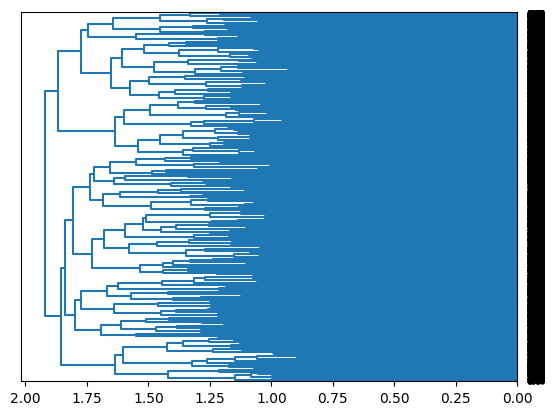

In [10]:
# Compute the similarity using the spearman coefficient
cor_Mat = stats.spearmanr(df.T).correlation.astype(np.float32)
dist_card = 1 - cor_Mat

# Perform hierarchical clustering
hr = linkage(squareform(dist_card), method='complete')

# Plot the results
dendrogram(hr, color_threshold=0)
plt.show()

dendrogram(hr, color_threshold=0, orientation='left')
plt.show()

In [15]:
cor_Mat = stats.spearmanr(df.T).correlation.astype(np.float32)
dist_card = 1 - cor_Mat

# 대각 요소를 0으로 설정
np.fill_diagonal(dist_card, 0)

# 계층적 클러스터링 수행
hr = linkage(squareform(dist_card), method='complete')

# 군집수를 2개부터 10개까지 2단위로 증가시키며 군집화 타당성 지표(Silhouette Score) 계산
n_clusters_list = range(2, 11, 2)
silhouette_scores = []

for n_clusters in n_clusters_list:
    # 클러스터 할당
    mycl = cut_tree(hr, n_clusters=n_clusters).flatten()

    # 실루엣 점수 계산
    score = silhouette_score(dist_card, mycl, metric='precomputed')
    silhouette_scores.append(score)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {score}")

Number of clusters: 2, Silhouette Score: 0.1251230537891388
Number of clusters: 4, Silhouette Score: 0.10032981634140015
Number of clusters: 6, Silhouette Score: 0.07675673067569733
Number of clusters: 8, Silhouette Score: 0.05836426466703415
Number of clusters: 10, Silhouette Score: 0.033053528517484665


In [23]:
n_clusters_list = range(2, 7)
silhouette_scores = []
for n_clusters in n_clusters_list:
    # 클러스터 할당
    mycl = cut_tree(hr, n_clusters=n_clusters).flatten()

    # 실루엣 점수 계산
    score = silhouette_score(dist_card, mycl, metric='precomputed')
    silhouette_scores.append(score)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {score}")

Number of clusters: 2, Silhouette Score: 0.1251230537891388
Number of clusters: 3, Silhouette Score: 0.11850004643201828
Number of clusters: 4, Silhouette Score: 0.10032981634140015
Number of clusters: 5, Silhouette Score: 0.08466729521751404
Number of clusters: 6, Silhouette Score: 0.07675673067569733


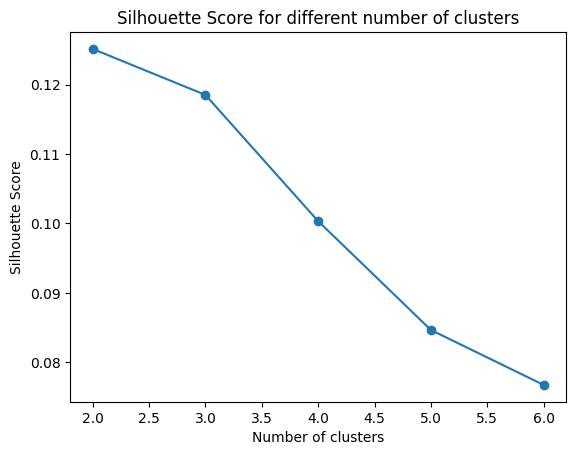

In [24]:
plt.plot(n_clusters_list, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters')
plt.show()

Number of clusters: 2, Silhouette Score: 0.03738201782107353
Number of clusters: 4, Silhouette Score: -0.16140007972717285
Number of clusters: 6, Silhouette Score: -0.21519459784030914
Number of clusters: 8, Silhouette Score: -0.2701975405216217
Number of clusters: 10, Silhouette Score: -0.2915341854095459


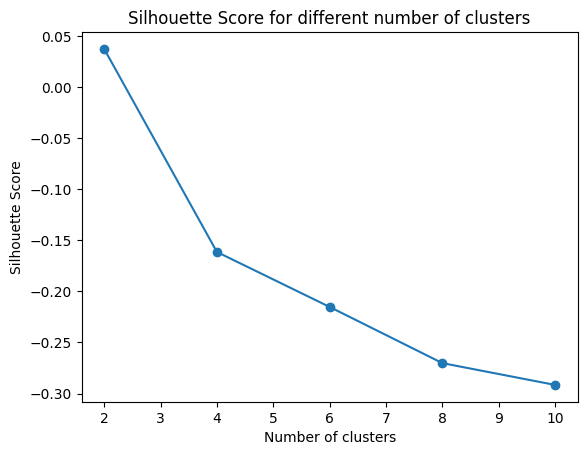

In [18]:
hr_s = linkage(squareform(dist_card), method='single')

# 군집수를 2개부터 10개까지 2단위로 증가시키며 군집화 타당성 지표(Silhouette Score) 계산
n_clusters_list = range(2, 11, 2)
silhouette_scores = []

for n_clusters in n_clusters_list:
    # 클러스터 할당
    mycl = cut_tree(hr_s, n_clusters=n_clusters).flatten()

    # 실루엣 점수 계산
    score = silhouette_score(dist_card, mycl, metric='precomputed')
    silhouette_scores.append(score)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {score}")

# 결과 시각화
plt.plot(n_clusters_list, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters')
plt.show()

In [25]:
n_clusters_list = range(2, 5)
silhouette_scores = []
for n_clusters in n_clusters_list:
    # 클러스터 할당
    mycl = cut_tree(hr_s, n_clusters=n_clusters).flatten()

    # 실루엣 점수 계산
    score = silhouette_score(dist_card, mycl, metric='precomputed')
    silhouette_scores.append(score)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {score}")

Number of clusters: 2, Silhouette Score: 0.03738201782107353
Number of clusters: 3, Silhouette Score: -0.08929658681154251
Number of clusters: 4, Silhouette Score: -0.16140007972717285


#### 3-Q7`

In [27]:
mycl = cut_tree(hr, n_clusters=3).flatten()
mycl_s = cut_tree(hr_s, n_clusters=2).flatten()

In [30]:
cluster_hc = pd.concat([
    pd.DataFrame(df, columns=X),
    pd.DataFrame(mycl, columns=['clusterID'])
], axis=1)

hc_summary = pd.DataFrame()
for col in cluster_hc.iloc[:, :-1].columns:
    hc_summary = pd.concat([hc_summary, cluster_hc.groupby('clusterID')[col].mean()], axis=1)

hc_summary = hc_summary.T
hc_summary.columns = ['cluster' + str(i) for i in range(1,4)]
hc_summary.index = X
hc_summary

,cluster1,cluster2,cluster3
State,-0.020990,0.007839,0.002040
Customer Lifetime Value,-0.038927,-0.046817,0.027815
Response,-0.054061,0.075255,-0.016315
Coverage,-0.032119,0.040004,-0.007849
Education,-0.121611,-0.036161,0.043772
EmploymentStatus,0.042577,1.380677,-0.551168
Gender,-0.033022,0.048272,-0.010868
Income,-0.079313,-1.100753,0.450468
Location Code,0.330730,0.034524,-0.094044
Marital Status,0.086039,0.409079,-0.181181


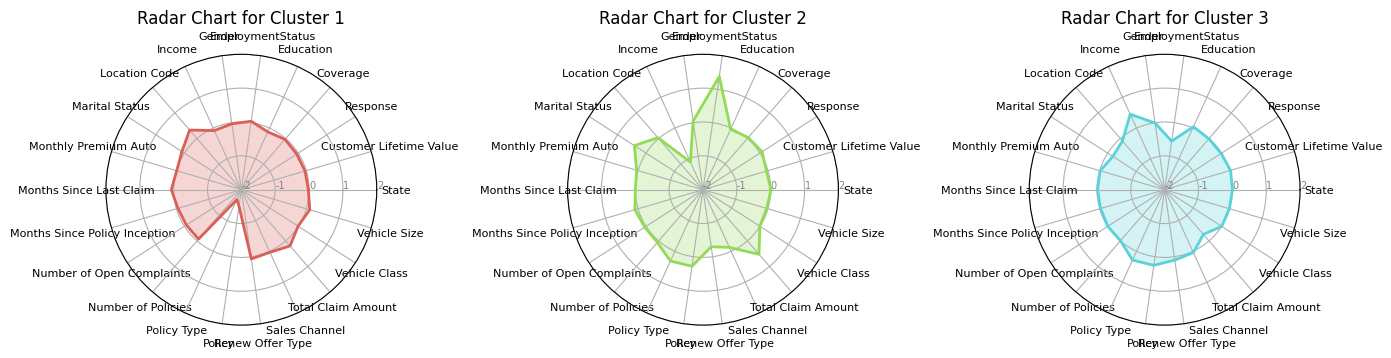

In [33]:
# Plotting the Radar Chart
categories = hc_summary.index.tolist()
N = len(categories)

# Divide the plot / number of variable
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(1, 3, figsize=(14, 10), subplot_kw=dict(projection="polar"))
ax = ax.flatten()

# Plot each individual = each line of the data
colors = sns.color_palette("hls", 4)

for i in range(hc_summary.shape[1]):
    values = hc_summary.iloc[:, i].values.flatten().tolist()
    values += values[:1]
    ax[i].plot(angles, values, linewidth=2, linestyle='solid', label="Cluster " + str(i+1), color=colors[i])
    ax[i].fill(angles, values, color=colors[i], alpha=0.25)

    # 각 변수에 대해 라벨 설정
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(categories, color='black', size=8)

    # y축 라벨 설정
    ax[i].set_rlabel_position(0)
    ax[i].set_yticks([-2, -1, 0, 1, 2])
    ax[i].set_yticklabels(["-2", "-1", "0", "1", "2"], color="grey", size=7)

    # 타이틀 설정
    ax[i].set_title(f'Radar Chart for Cluster {i+1}')

plt.tight_layout()
plt.show()

In [31]:
cluster_hc_s = pd.concat([
    pd.DataFrame(df, columns=X),
    pd.DataFrame(mycl_s, columns=['clusterID'])
], axis=1)

hc_summary_s = pd.DataFrame()
for col in cluster_hc_s.iloc[:, :-1].columns:
    hc_summary_s = pd.concat([hc_summary_s, cluster_hc_s.groupby('clusterID')[col].mean()], axis=1)

hc_summary_s = hc_summary_s.T
hc_summary_s.columns = ['cluster' + str(i) for i in range(1,3)]
hc_summary_s.index = X
hc_summary_s

,cluster1,cluster2
State,-0.000192,1.753720
Customer Lifetime Value,-0.000004,0.037630
Response,0.000045,-0.408822
Coverage,-0.000087,0.791999
Education,-0.000115,1.046323
EmploymentStatus,-0.000177,1.613313
Gender,-0.000112,1.020128
Income,0.000136,-1.239617
Location Code,0.000177,-1.616461
Marital Status,0.000021,-0.188771


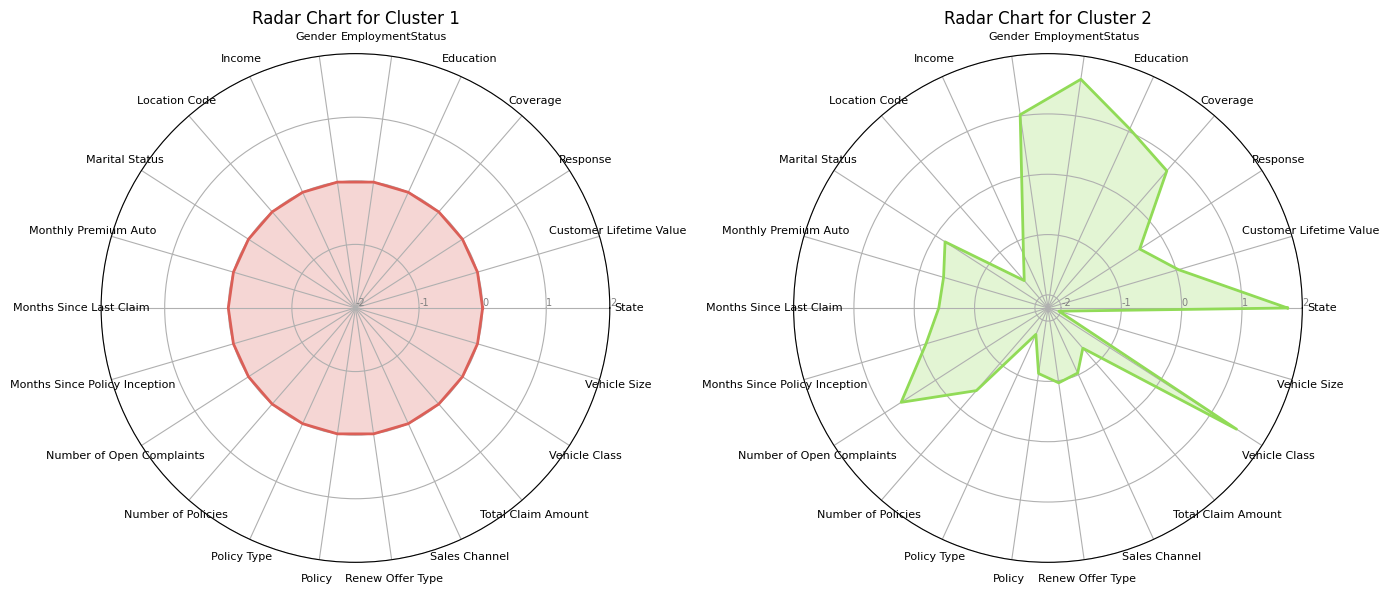

In [34]:
# Plotting the Radar Chart
categories = hc_summary_s.index.tolist()
N = len(categories)

# Divide the plot / number of variable
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(1, 2, figsize=(14, 10), subplot_kw=dict(projection="polar"))
ax = ax.flatten()

# Plot each individual = each line of the data
colors = sns.color_palette("hls", 4)

for i in range(hc_summary_s.shape[1]):
    values = hc_summary_s.iloc[:, i].values.flatten().tolist()
    values += values[:1]
    ax[i].plot(angles, values, linewidth=2, linestyle='solid', label="Cluster " + str(i+1), color=colors[i])
    ax[i].fill(angles, values, color=colors[i], alpha=0.25)

    # 각 변수에 대해 라벨 설정
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(categories, color='black', size=8)

    # y축 라벨 설정
    ax[i].set_rlabel_position(0)
    ax[i].set_yticks([-2, -1, 0, 1, 2])
    ax[i].set_yticklabels(["-2", "-1", "0", "1", "2"], color="grey", size=7)

    # 타이틀 설정
    ax[i].set_title(f'Radar Chart for Cluster {i+1}')

plt.tight_layout()
plt.show()

### 4` DBSCAN

#### 4-Q8`

In [42]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

# 탐색할 eps와 minPts 값의 범위
eps_values = np.arange(1, 6, 0.5)
minPts_values = range(1, 7)

# 결과 저장용 리스트
results = []

# eps와 minPts 값을 조정하며 군집 수를 계산
for eps in eps_values:
    for minPts in minPts_values:
        # DBSCAN 모델 생성 및 군집화 수행
        dbscan = DBSCAN(eps=eps, min_samples=minPts)
        labels = dbscan.fit_predict(df)

        # 군집 수 계산 (-1 레이블은 노이즈로 간주)
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # 결과 저장
        results.append((eps, minPts, num_clusters))
        print(f"eps: {eps}, minPts: {minPts}, Number of clusters: {num_clusters}")

# 결과를 데이터프레임으로 변환 (옵션)
results_df = pd.DataFrame(results, columns=['eps', 'minPts', 'num_clusters'])
results_df

eps: 1.0, minPts: 1, Number of clusters: 8528
eps: 1.0, minPts: 2, Number of clusters: 326
eps: 1.0, minPts: 3, Number of clusters: 158
eps: 1.0, minPts: 4, Number of clusters: 73
eps: 1.0, minPts: 5, Number of clusters: 20
eps: 1.0, minPts: 6, Number of clusters: 1
eps: 1.5, minPts: 1, Number of clusters: 8334
eps: 1.5, minPts: 2, Number of clusters: 438
eps: 1.5, minPts: 3, Number of clusters: 189
eps: 1.5, minPts: 4, Number of clusters: 102
eps: 1.5, minPts: 5, Number of clusters: 33
eps: 1.5, minPts: 6, Number of clusters: 3
eps: 2.0, minPts: 1, Number of clusters: 7516
eps: 2.0, minPts: 2, Number of clusters: 701
eps: 2.0, minPts: 3, Number of clusters: 328
eps: 2.0, minPts: 4, Number of clusters: 204
eps: 2.0, minPts: 5, Number of clusters: 127
eps: 2.0, minPts: 6, Number of clusters: 41
eps: 2.5, minPts: 1, Number of clusters: 4938
eps: 2.5, minPts: 2, Number of clusters: 680
eps: 2.5, minPts: 3, Number of clusters: 339
eps: 2.5, minPts: 4, Number of clusters: 238
eps: 2.5, minP

,eps,minPts,num_clusters
0,1.0,1,8528
1,1.0,2,326
2,1.0,3,158
3,1.0,4,73
4,1.0,5,20
5,1.0,6,1
6,1.5,1,8334
7,1.5,2,438
8,1.5,3,189
9,1.5,4,102


#### 4-Q9`

In [69]:
db = DBSCAN(eps=4.5, min_samples=2).fit(df)

# 라벨 추출 (-1은 노이즈를 의미)
labels = db.labels_

# 노이즈 객체 수 계산
n_noise = list(labels).count(-1)

print(f"Noise 객체의 수: {n_noise}개")

Noise 객체의 수: 28개


In [71]:
labels = db.fit_predict(df)

# 클러스터별 개수 계산
unique_labels, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))

# 클러스터별 개수 출력
for label, count in cluster_counts.items():
    if label == -1:
        print(f"Noise points: {count}")
    else:
        print(f"Cluster {label}: {count} points")

Noise points: 28
Cluster 0: 9092 points
Cluster 1: 6 points
Cluster 2: 2 points
Cluster 3: 6 points


In [66]:
for eps in eps_values:
    for minPts in minPts_values:
        # DBSCAN 모델 생성 및 군집화 수행
        dbscan = DBSCAN(eps=eps, min_samples=minPts)
        labels = dbscan.fit_predict(df)

        # 군집 수 계산 (-1 레이블은 노이즈로 간주)
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # 노이즈 개수 계산
        num_noise = list(labels).count(-1)

        # 결과 저장
        results.append((eps, minPts, num_clusters, num_noise))
        print(f"eps: {eps}, minPts: {minPts}, Number of clusters: {num_clusters}, Number of noise points: {num_noise}")

# 결과를 데이터프레임으로 변환 (옵션)
results_df = pd.DataFrame(results, columns=['eps', 'minPts', 'num_clusters', 'num_noise'])
results_df

eps: 1.0, minPts: 1, Number of clusters: 8528, Number of noise points: 0
eps: 1.0, minPts: 2, Number of clusters: 326, Number of noise points: 8202
eps: 1.0, minPts: 3, Number of clusters: 158, Number of noise points: 8538
eps: 1.0, minPts: 4, Number of clusters: 73, Number of noise points: 8807
eps: 1.0, minPts: 5, Number of clusters: 20, Number of noise points: 9033
eps: 1.0, minPts: 6, Number of clusters: 1, Number of noise points: 9128
eps: 1.5, minPts: 1, Number of clusters: 8334, Number of noise points: 0
eps: 1.5, minPts: 2, Number of clusters: 438, Number of noise points: 7896
eps: 1.5, minPts: 3, Number of clusters: 189, Number of noise points: 8394
eps: 1.5, minPts: 4, Number of clusters: 102, Number of noise points: 8675
eps: 1.5, minPts: 5, Number of clusters: 33, Number of noise points: 8964
eps: 1.5, minPts: 6, Number of clusters: 3, Number of noise points: 9116
eps: 2.0, minPts: 1, Number of clusters: 7516, Number of noise points: 0
eps: 2.0, minPts: 2, Number of cluster

,eps,minPts,num_clusters,num_noise
0,1.0,1,8528,NaN
1,1.0,2,326,NaN
2,1.0,3,158,NaN
3,1.0,4,73,NaN
4,1.0,5,20,NaN
...,...,...,...,...
115,5.5,2,1,2.0
116,5.5,3,1,2.0
117,5.5,4,1,2.0
118,5.5,5,1,2.0


In [67]:
db = DBSCAN(eps=4.5, min_samples=2).fit(df)
labels = db.fit_predict(df)
# 노이즈 데이터 제외 (-1 레이블 제거)
filtered_labels = labels[labels != -1]
filtered_data = df[labels != -1]

# 실루엣 스코어 계산
len(set(filtered_labels)) > 1:  # 군집이 하나 이상일 때만 계산
silhouette_avg = silhouette_score(filtered_data, filtered_labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.17640620351834466
